In [1]:
import torch
from torch import nn
from torch.nn import functional as F

## Key Ideas
Similarly to Lasso regression which assigns zero weights to the most irrelevant or redundant features, LassoNet, achieves feature selection by adding a residual layer at the inputs allowing a feature to participate in any hidden layer only if its skip-layer representative is active. <br/> <br/> 
Main attributes:
- Linear and non-linear data sets: at its core LassoNet involves a nonconver optimization problem
- The feature sparsity identification is generic and could be extended to other neural networks
- In addition of the neural network hyperparameters, only one hyperparameter **M** to tune: the hierarchy coefficient
- Extension to Unsupervised Feature Selection and Matrix Completion
- Python code and documentation for LassoNet is available at https://lassonet.ml

The lassoNet objective function is defined as:
$$
    \text{minimize}_{\theta, W} L(\theta, W) + \lambda ||\theta||_1
$$
$$
    \text{subject to } ||W_j^{(1)}||_\inf \le M |\theta_j|, ~ j=1,\cdots,d
$$
Where 
- $d$ denotes the number of features 
- $\theta \in \mathbb{R}$ are the weights in the residual layer
- $W_j^{(1)}$ are the weights for feature $j$ in the first  hidden layer

The optimization problem becomes:
$$
 \mathrm{argmin} \frac{1}{2} (||v-b||_2^2 + ||u-w||_2^2) + \lambda ||b||_2 + \lambda ||w||_2
$$
$$
 \text{subject to } ||w||_\inf \le M . ||b||_2
$$
where $u$ the weights of the first hiden layer and $v$ is the weights of the residual layer.

Algorithm:
1. Order the coordinates ${|u_i|}$ in decreasing order
$$
|u_1| \ge |u_2| \ge \cdots \ge |u_k|
$$
2. Define for each $s \in [K] = {0,1,\cdots,K}$ the value $b_s$ by
$$
b_s = \frac{1} {1 + sM^2}  \big(1- \frac{a_s} {||v||_2} \big)
~ \text{where } a_s = \lambda -M \sum_{i=1}^s (|u_i| - \bar{\lambda})
$$
Then $b^*=b_{s^*}$ satisfies $M ||b_s||_2 \in [\mathcal{S}_{\bar{\lambda}(|u_{s+1}|)}, \mathcal{S}_{\bar{\lambda}(|u_{s}|)}]$
3. $w^*$ must satisfy
$$
    w^* = \text{sign}(u) \min\big({M ||b^*||_2, \mathcal{S}_{\bar{\lambda}(|u|)})} \big)
$$

# LassoNet Architecture
- Adam optimizer with a learning rate of 10^3 to train the initial dense model. 
- Then, vanilla gradient descent with momentum equal to 0.9 on the regularization path. 
- One hidden-layer feed-forward neural network with ReLU activation function.
- Learning rate of 0.001 and early stopping criterion of 10

In [2]:
def soft_threshold(l, x):
    return torch.sign(x) * torch.relu(torch.abs(x) - l)

def sign_binary(x):
    ones = torch.ones_like(x)
    return torch.where(x >= 0, ones, -ones)

def prox(v, u, 
         /,
         *, 
         lambda_ = 0.1, 
         lambda_bar = 0, 
        M = 1):
    """
    v has shape (m,) or (m, batches)
    u has shape (k,) or (k, batches)

    """
    onedim = len(v.shape) == 1
    if onedim:
        v = v.unsqueeze(-1)
        u = u.unsqueeze(-1)

    u_abs_sorted = torch.sort(u.abs(), dim=0, descending=True).values

    k, batch = u.shape

    s = torch.arange(k + 1.0).view(-1, 1).to(v)
    zeros = torch.zeros(1, batch).to(u)

    a_s = lambda_ - M * torch.cat(
        [zeros, torch.cumsum(u_abs_sorted - lambda_bar, dim=0)]
    )

    norm_v = torch.norm(v, p=2, dim=0)

    x = F.relu(1 - a_s / norm_v) / (1 + s * M ** 2)

    w = M * x * norm_v
    intervals = soft_threshold(lambda_bar, u_abs_sorted)
    lower = torch.cat([intervals, zeros])

    idx = torch.sum(lower > w, dim=0).unsqueeze(0)

    x_star = torch.gather(x, 0, idx).view(1, batch)
    w_star = torch.gather(w, 0, idx).view(1, batch)

    beta_star = x_star * v
    theta_star = sign_binary(u) * torch.min(soft_threshold(lambda_bar, u.abs()), w_star)

    if onedim:
        beta_star.squeeze_(-1)
        theta_star.squeeze_(-1)

    return beta_star, theta_star

def inplace_prox(beta, theta, lambda_, lambda_bar, M):
      beta.weight.data, theta.weight.data = prox(
        beta.weight.data, theta.weight.data, lambda_=lambda_, lambda_bar=lambda_bar, M=M
      )

In [3]:
from itertools import islice

class LassoNet(nn.Module):
    def __init__(self, *dims, groups=None, dropout=None):
        """
        first dimension is input
        last dimension is output
        """
        assert len(dims) > 2
        super().__init__()

        self.dropout = nn.Dropout(p=dropout) if dropout is not None else None
        self.layers = nn.ModuleList(
            [nn.Linear(dims[i], dims[i + 1]) for i in range(len(dims) - 1)]
        )
        self.skip = nn.Linear(dims[0], dims[-1], bias=False)

    def forward(self, inp):
        current_layer = inp
        result = self.skip(inp)
        for theta in self.layers:
            current_layer = theta(current_layer)
            if theta is not self.layers[-1]:
                if self.dropout is not None:
                    current_layer = self.dropout(current_layer)
                current_layer = F.relu(current_layer)
        return result + current_layer

    def prox(self, *, lambda_, lambda_bar=0, M=1):
            with torch.no_grad():
                inplace_prox(
                    beta=self.skip,
                    theta=self.layers[0],
                    lambda_=lambda_,
                    lambda_bar=lambda_bar,
                    M=M,
                )
    ## 
    # This method is  used to determine a starting value for the "lambda_" parameter 
    # in the "prox" function that is used to sparsify the model.
    ##
    def lambda_start(
        self,
        M=1,
        lambda_bar=0,
        factor=2,
    ):
        """Estimate when the model will start to sparsify."""

        def is_sparse(lambda_):
            with torch.no_grad():
                beta = self.skip.weight.data
                theta = self.layers[0].weight.data

                for _ in range(10000):
                    new_beta, theta = prox(
                        beta,
                        theta,
                        lambda_=lambda_,
                        lambda_bar=lambda_bar,
                        M=M,
                    )
                    if torch.abs(beta - new_beta).max() < 1e-5:
                        # print(_)
                        break
                    beta = new_beta
                return (torch.norm(beta, p=2, dim=0) == 0).sum()

        start = 1e-6
        while not is_sparse(factor * start):
            start *= factor
        return start
    
    def l2_regularization(self):
        """
        L2 regulatization of the MLP without the first layer
        which is bounded by the skip connection
        """
        ans = 0
        for layer in islice(self.layers, 1, None):
            ans += (
                torch.norm(
                    layer.weight.data,
                    p=2,
                )
                ** 2
            )
        return ans
    
    def l1_regularization_skip(self):
        return torch.norm(self.skip.weight.data, p=2, dim=0).sum()

    # The skip connection is regularized independently for the rest of nnet.
    def l2_regularization_skip(self):
        return torch.norm(self.skip.weight.data, p=2)

    # Select the weights of the skip connection not being 0.
    def input_mask(self):
        with torch.no_grad():
            return torch.norm(self.skip.weight.data, p=2, dim=0) != 0

    def selected_count(self):
        return self.input_mask().sum().item()
    
    def cpu_state_dict(self):
        return {k: v.detach().clone().cpu() for k, v in self.state_dict().items()}    

In [4]:
data = [[1, 2],[3, 4]]
v = torch.tensor(data,  dtype=torch.float64)
data = [[-3, -1],[2, -4]]
u = torch.tensor(data)

In [5]:
prox(v,u)

(tensor([[0.9684, 1.9553],
         [2.9051, 3.9106]], dtype=torch.float64),
 tensor([[-3., -1.],
         [ 2., -4.]], dtype=torch.float64))

In [6]:
from dataclasses import dataclass
from functools import partial

@dataclass
class HistoryItem:
    lambda_: float
    state_dict: dict
    objective: float  # loss + lambda_ * regularization
    loss: float
    val_objective: float  # val_loss + lambda_ * regularization
    val_loss: float
    regularization: float
    l2_regularization: float
    l2_regularization_skip: float
    selected: torch.BoolTensor
    n_iters: int

    def log(item):
        print(
            f"{item.n_iters} epochs, "
            f"val_objective "
            f"{item.val_objective:.2e}, "
            f"val_loss "
            f"{item.val_loss:.2e}, "
            f"regularization {item.regularization:.2e}, "
            f"l2_regularization {item.l2_regularization:.2e}"
        )

In [7]:
from abc import ABCMeta
from sklearn.base import BaseEstimator
from typing import List
import itertools

class BaseLassoNet(BaseEstimator, metaclass=ABCMeta):
    def __init__(
        self,
        *,
        hidden_dims=(100,),
        lambda_start="auto",
        lambda_seq=None,
        gamma=0.0,
        gamma_skip=0.0,
        path_multiplier=1.02,
        M=10,
        groups=None,
        dropout=0,
        batch_size=None,
        optim=None,
        n_iters=(1000, 100),
        patience=(100, 10),
        tol=0.99,
        backtrack=False,
        val_size=None,
        device=None,
        verbose=1,
        random_state=None,
        torch_seed=None,
        class_weight=None,
        tie_approximation=None,
    ):
        assert isinstance(hidden_dims, tuple), "`hidden_dims` must be a tuple"
        self.hidden_dims = hidden_dims
        self.lambda_start = lambda_start
        self.lambda_seq = lambda_seq
        self.gamma = gamma
        self.gamma_skip = gamma_skip
        self.path_multiplier = path_multiplier
        self.M = M
        self.groups = groups
        self.dropout = dropout
        self.batch_size = batch_size
        self.optim = optim
        if optim is None:
            optim = (
                partial(torch.optim.Adam, lr=1e-3),
                partial(torch.optim.SGD, lr=1e-3, momentum=0.9),
            )
        if isinstance(optim, partial):
            optim = (optim, optim)
        self.optim_init, self.optim_path = optim
        if isinstance(n_iters, int):
            n_iters = (n_iters, n_iters)
        self.n_iters = self.n_iters_init, self.n_iters_path = n_iters
        if patience is None or isinstance(patience, int):
            patience = (patience, patience)
        self.patience = self.patience_init, self.patience_path = patience
        self.tol = tol
        self.backtrack = backtrack
        val_size = 0.1
        self.val_size = val_size

        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device

        self.verbose = verbose
        self.random_state = random_state
        self.torch_seed = torch_seed

        self.model = None
        self.class_weight = class_weight
        self.tie_approximation = tie_approximation

        if self.class_weight is not None:
            assert isinstance(
                self, LassoNetClassifier
            ), "Weighted loss is only for classification"
            self.class_weight = torch.FloatTensor(self.class_weight).to(self.device)
            self.criterion = torch.nn.CrossEntropyLoss(
                weight=self.class_weight, reduction="mean"
            )
            
    def _init_model(self, X, y):
        """Create a torch model"""
        output_shape = self._output_shape(y)
        if self.torch_seed is not None:
            torch.manual_seed(self.torch_seed)
        self.model = LassoNet(
            X.shape[1],
            *self.hidden_dims,
            output_shape,
            groups=self.groups,
            dropout=self.dropout,
        ).to(self.device)

    def _cast_input(self, X, y=None):
        if hasattr(X, "to_numpy"):
            X = X.to_numpy()
        X = torch.FloatTensor(X).to(self.device)
        if y is None:
            return X
        if hasattr(y, "to_numpy"):
            y = y.to_numpy()
        y = self._convert_y(y)
        return X, y

    def fit(self, X, y, *, X_val=None, y_val=None):
        """Train the model.
        Note that if `lambda_` is not given, the trained model
        will most likely not use any feature.
        """
        self.path_ = self.path(X, y, X_val=X_val, y_val=y_val, return_state_dicts=False)
        return self
            
    def _train(
        self,
        X_train,
        y_train,
        X_val,
        y_val,
        *,
        batch_size,
        epochs,
        lambda_,
        optimizer,
        return_state_dict,
        patience=None,
    ) -> HistoryItem:
        model = self.model

        def validation_obj():
            with torch.no_grad():
                return (
                    self.criterion(model(X_val), y_val).item()
                    + lambda_ * model.l1_regularization_skip().item()
                    + self.gamma * model.l2_regularization().item()
                    + self.gamma_skip * model.l2_regularization_skip().item()
                )

        best_val_obj = validation_obj()
        epochs_since_best_val_obj = 0
        if self.backtrack:
            best_state_dict = self.model.cpu_state_dict()
            real_best_val_obj = best_val_obj
            real_loss = float("nan")  # if epochs == 0

        n_iters = 0

        n_train = len(X_train)
        if batch_size is None:
            batch_size = n_train
            randperm = torch.arange
        else:
            randperm = torch.randperm
        batch_size = min(batch_size, n_train)

        for epoch in range(epochs):
            indices = randperm(n_train)
            model.train()
            loss = 0
            for i in range(n_train // batch_size):
                # don't take batches that are not full
                batch = indices[i * batch_size : (i + 1) * batch_size]

                def closure():
                    nonlocal loss
                    optimizer.zero_grad()
                    ans = (
                        self.criterion(model(X_train[batch]), y_train[batch])
                        + self.gamma * model.l2_regularization()
                        + self.gamma_skip * model.l2_regularization_skip()
                    )
                    if ans + 1 == ans:
                        print(f"Loss is {ans}", file=sys.stderr)
                        print(f"Did you normalize input?", file=sys.stderr)
                        print(
                            f"Loss: {self.criterion(model(X_train[batch]), y_train[batch])}"
                        )
                        print(f"l2_regularization: {model.l2_regularization()}")
                        print(
                            f"l2_regularization_skip: {model.l2_regularization_skip()}"
                        )
                        assert False
                    ans.backward()
                    loss += ans.item() * len(batch) / n_train
                    return ans

                optimizer.step(closure)
                # Notice that the \lambda parameter is the product of the current lambda
                # And the value of first layer (related to the features) learning rate
                model.prox(lambda_=lambda_ * optimizer.param_groups[0]["lr"], M=self.M)
            #print("epoch:", epoch)
            #print("loss:", loss)

            if epoch == 0:
                # fallback to running loss of first epoch
                real_loss = loss
            val_obj = validation_obj()
            if val_obj < self.tol * best_val_obj:
                best_val_obj = val_obj
                epochs_since_best_val_obj = 0
            else:
                epochs_since_best_val_obj += 1
            if self.backtrack and val_obj < real_best_val_obj:
                best_state_dict = self.model.cpu_state_dict()
                real_best_val_obj = val_obj
                real_loss = loss
                n_iters = epoch + 1
            if patience is not None and epochs_since_best_val_obj == patience:
                break

        if self.backtrack:
            self.model.load_state_dict(best_state_dict)
            val_obj = real_best_val_obj
            loss = real_loss
        else:
            n_iters = epoch + 1
        with torch.no_grad():
            reg = self.model.l1_regularization_skip().item()
            l2_regularization = self.model.l2_regularization()
            l2_regularization_skip = self.model.l2_regularization_skip()
        return HistoryItem(
            lambda_=lambda_,
            state_dict=self.model.cpu_state_dict() if return_state_dict else None,
            objective=loss + lambda_ * reg,
            loss=loss,
            val_objective=val_obj,
            val_loss=val_obj - lambda_ * reg,  # TODO remove l2 reg
            regularization=reg,
            l2_regularization=l2_regularization,
            l2_regularization_skip=l2_regularization_skip,
            selected=self.model.input_mask().cpu(),
            n_iters=n_iters,
        )        
    
    def path(
        self,
        X,
        y,
        *,
        X_val=None,
        y_val=None,
        lambda_seq=None,
        lambda_max=float("inf"),
        return_state_dicts=True,
        callback=None,
    ) -> List[HistoryItem]:
        """Train LassoNet on a lambda\_ path.
        The path is defined by the class parameters:
        start at `lambda_start` and increment according to `path_multiplier`.
        The path will stop when no feature is being used anymore.
        callback will be called at each step on (model, history)
        """
        assert (X_val is None) == (
            y_val is None
        ), "You must specify both or none of X_val and y_val"
        sample_val = self.val_size != 0 and X_val is None
        if sample_val:
            X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=self.val_size, random_state=self.random_state
            )
        elif X_val is None:
            X_train, y_train = X_val, y_val = X, y
        else:
            X_train, y_train = X, y
        X_train, y_train = self._cast_input(X_train, y_train)
        X_val, y_val = self._cast_input(X_val, y_val)

        hist: List[HistoryItem] = []

        # always init model
        self._init_model(X_train, y_train)

        hist.append(
            self._train(
                X_train,
                y_train,
                X_val,
                y_val,
                batch_size=self.batch_size,
                lambda_=0,
                epochs=self.n_iters_init,
                optimizer=self.optim_init(self.model.parameters()),
                patience=self.patience_init,
                return_state_dict=return_state_dicts,
            )
        )
        if callback is not None:
            callback(self, hist)
        if self.verbose > 1:
            print("Initialized dense model")
            hist[-1].log()

        optimizer = self.optim_path(self.model.parameters())

        # build lambda_seq
        if lambda_seq is not None:
            pass
        elif self.lambda_seq is not None:
            lambda_seq = self.lambda_seq
        else:

            def _lambda_seq(start):
                while start <= lambda_max:
                    yield start
                    start *= self.path_multiplier

            if self.lambda_start == "auto":
                # divide by 10 for initial training
                self.lambda_start_ = (
                    self.model.lambda_start(M=self.M)
                    / optimizer.param_groups[0]["lr"]
                    / 10
                )
                lambda_seq = _lambda_seq(self.lambda_start_)
            else:
                lambda_seq = _lambda_seq(self.lambda_start)

        # extract first value of lambda_seq
        lambda_seq = iter(lambda_seq)
        lambda_start = next(lambda_seq)

        is_dense = True
        for current_lambda in itertools.chain([lambda_start], lambda_seq):
            if self.model.selected_count() == 0:
                break
            last = self._train(
                X_train,
                y_train,
                X_val,
                y_val,
                batch_size=self.batch_size,
                lambda_=current_lambda,
                epochs=self.n_iters_path,
                optimizer=optimizer,
                patience=self.patience_path,
                return_state_dict=return_state_dicts,
            )
            if is_dense and self.model.selected_count() < X.shape[1]:
                is_dense = False
                if current_lambda / lambda_start < 2:
                    warnings.warn(
                        f"lambda_start={lambda_start:.3f} "
                        f"{'(selected automatically) ' * (self.lambda_start == 'auto')}"
                        "might be too large.\n"
                        f"Features start to disappear at {current_lambda=:.3f}."
                    )

            hist.append(last)
            if callback is not None:
                callback(self, hist)

            if self.verbose > 1:
                print(
                    f"Lambda = {current_lambda:.2e}, "
                    f"selected {self.model.selected_count()} features "
                )
                last.log()

        """When does each feature disappear on the path?"""
        self.feature_importances_ = self._compute_feature_importances(hist)

        return hist    

    @staticmethod
    def _compute_feature_importances(path: List[HistoryItem]):
        """When does each feature disappear on the path?

        Parameters
        ----------
        path : List[HistoryItem]

        Returns
        -------
            feature_importances_
        """
        current = path[0].selected.clone()
        ans = torch.full(current.shape, float("inf"))
        for save in islice(path, 1, None):
            lambda_ = save.lambda_
            diff = current & ~save.selected
            ans[diff.nonzero().flatten()] = lambda_
            current &= save.selected
        return ans    
        
    def load(self, state_dict):
        if isinstance(state_dict, HistoryItem):
            state_dict = state_dict.state_dict
        if self.model is None:
            output_shape, input_shape = state_dict["skip.weight"].shape
            self.model = LassoNet(
                input_shape,
                *self.hidden_dims,
                output_shape,
                groups=self.groups,
                dropout=self.dropout,
            ).to(self.device)

        self.model.load_state_dict(state_dict)
        return self        

In [8]:
from sklearn.base import (
    BaseEstimator,
    ClassifierMixin,
)
class LassoNetClassifier(
    ClassifierMixin,
    BaseLassoNet,
):
    """Use LassoNet as classifier"""

    criterion = torch.nn.CrossEntropyLoss(reduction="mean")

    def _convert_y(self, y) -> torch.TensorType:
        y = torch.LongTensor(y).to(self.device)
        assert len(y.shape) == 1, "y must be 1D"
        return y

    @staticmethod
    def _output_shape(y):
        return (y.max() + 1).item()

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            ans = self.model(self._cast_input(X)).argmax(dim=1)
        if isinstance(X, np.ndarray):
            ans = ans.cpu().numpy()
        return ans

    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            ans = torch.softmax(self.model(self._cast_input(X)), -1)
        if isinstance(X, np.ndarray):
            ans = ans.cpu().numpy()
        return ans

In [16]:
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

X, y = fetch_openml(name="miceprotein", return_X_y=True)

feature_names = fetch_openml(name="miceprotein")["feature_names"]
n_features = X.shape[1]


# Fill missing values with the mean
X = SimpleImputer().fit_transform(X)
# Convert labels to scalar
y = LabelEncoder().fit_transform(y)

# standardize
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [17]:
import matplotlib.pyplot as plt

In [18]:
%%time
model = LassoNetClassifier()
path = model.path(X_train, y_train)

CPU times: user 1min 45s, sys: 1.56 s, total: 1min 46s
Wall time: 36.9 s


In [19]:
model.model

LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=77, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=8, bias=True)
  )
  (skip): Linear(in_features=77, out_features=8, bias=False)
)

In [20]:
def eval_on_path(model, path, X_test, y_test, *, score_function=None):
    if score_function is None:
        score_fun = model.score
    else:
        assert callable(score_function)

        def score_fun(X_test, y_test):
            return score_function(y_test, model.predict(X_test))

    score = []
    for save in path:
        model.load(save.state_dict)
        score.append(score_fun(X_test, y_test))
    return score

def plot_path(model, path, X_test, y_test, *, score_function=None):
    """
    Plot the evolution of the model on the path, namely:
    - lambda
    - number of selected variables
    - score


    Parameters
    ==========
    model : LassoNetClassifier or LassoNetRegressor
    path
        output of model.path
    X_test : array-like
    y_test : array-like
    score_function : function or None
        if None, use score_function=model.score
        score_function must take as input X_test, y_test
    """
    # TODO: plot with manually computed score
    score = eval_on_path(model, path, X_test, y_test, score_function=score_function)
    n_selected = [save.selected.sum() for save in path]
    lambda_ = [save.lambda_ for save in path]

    plt.figure(figsize=(16, 16))

    plt.subplot(311)
    plt.grid(True)
    plt.plot(n_selected, score, ".-")
    plt.xlabel("number of selected features")
    plt.ylabel("score")

    plt.subplot(312)
    plt.grid(True)
    plt.plot(lambda_, score, ".-")
    plt.xlabel("lambda")
    plt.xscale("log")
    plt.ylabel("score")

    plt.subplot(313)
    plt.grid(True)
    plt.plot(lambda_, n_selected, ".-")
    plt.xlabel("lambda")
    plt.xscale("log")
    plt.ylabel("number of selected features")

    plt.tight_layout()

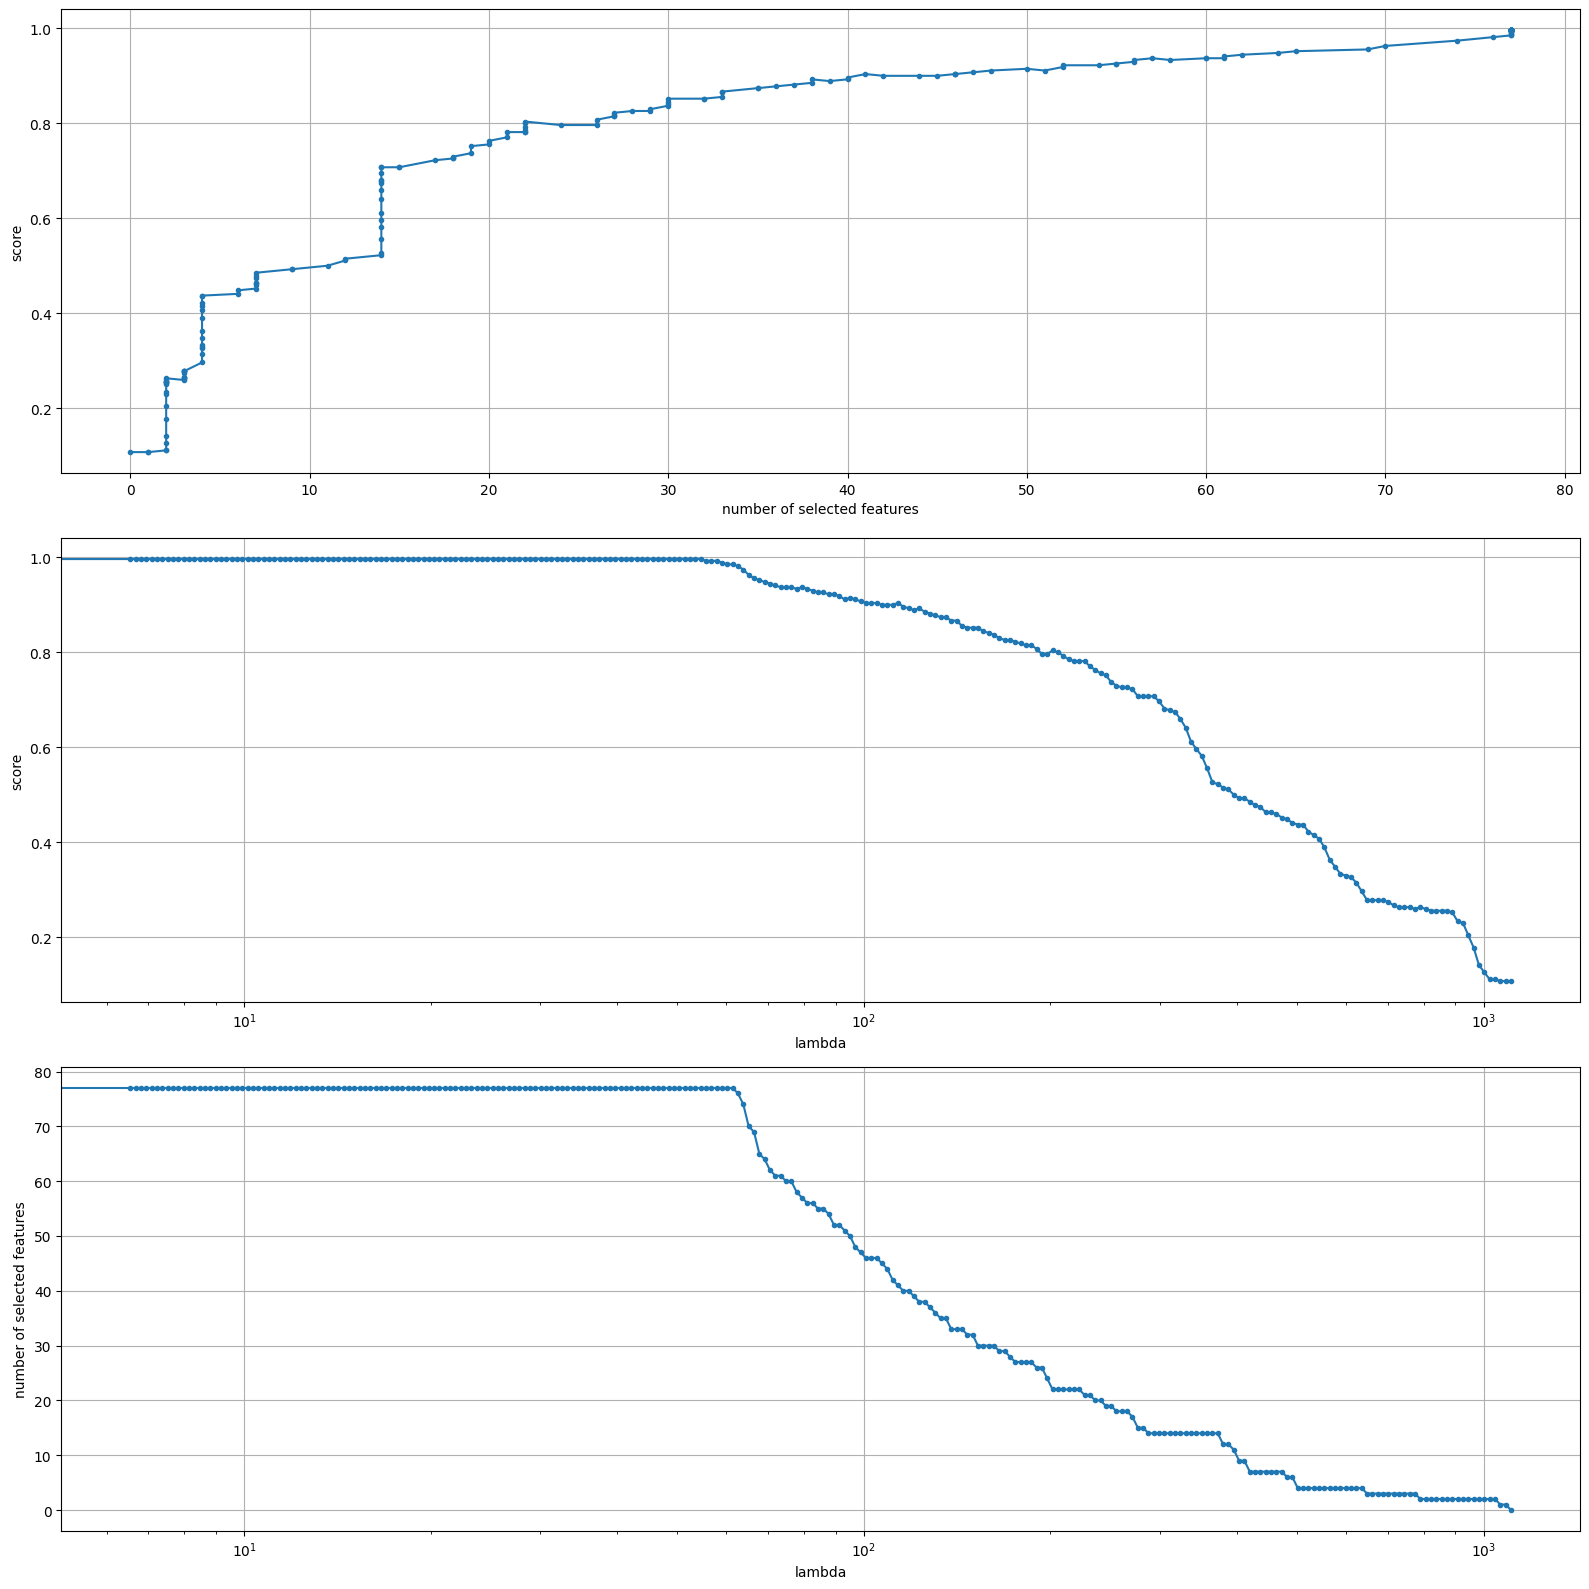

In [21]:
plot_path(model, path, X_test, y_test)
# plt.savefig("miceprotein.png")

In [82]:
def model_for_accuracy(model, path, X_test, y_test, target_score, *, epsilon=0.01):
    scores = eval_on_path(model, path, X_test, y_test, score_function=None)
    hist = {}
    for save in path:
        model.load(save.state_dict)
        score = model.score(X_test, y_test)
        if (score >= target_score) and score<= (target_score + epsilon):
            hist[score] = save
    sorted_keys = list(hist.keys()) 
    sorted_keys.sort()
    return [hist[i] for i in sorted_keys[::-1]][0]

def get_features(model, path, X_test, y_test, target_score):
    # Get selected features
    save = model_for_accuracy(model, path, X_test, y_test, target_score)
    idxs = torch.nonzero(save.selected == True)  
    return idxs.flatten().numpy()

# Retrieve the model with least features for a given accuracy

In [83]:
at_target_accuracy_feature_idx = get_features(model, path, X_test, y_test, 0.8)
at_target_accuracy_feature_idx

array([ 4,  7, 11, 14, 15, 17, 19, 30, 32, 33, 34, 39, 42, 43, 45, 46, 48,
       49, 52, 53, 55, 56, 58, 65, 70, 76])

In [85]:
true_features = len(at_target_accuracy_feature_idx)
importances = model.feature_importances_.numpy()
order = np.argsort(importances)[::-1]
importances = importances[order]
ordered_feature_names = [feature_names[i] for i in order]

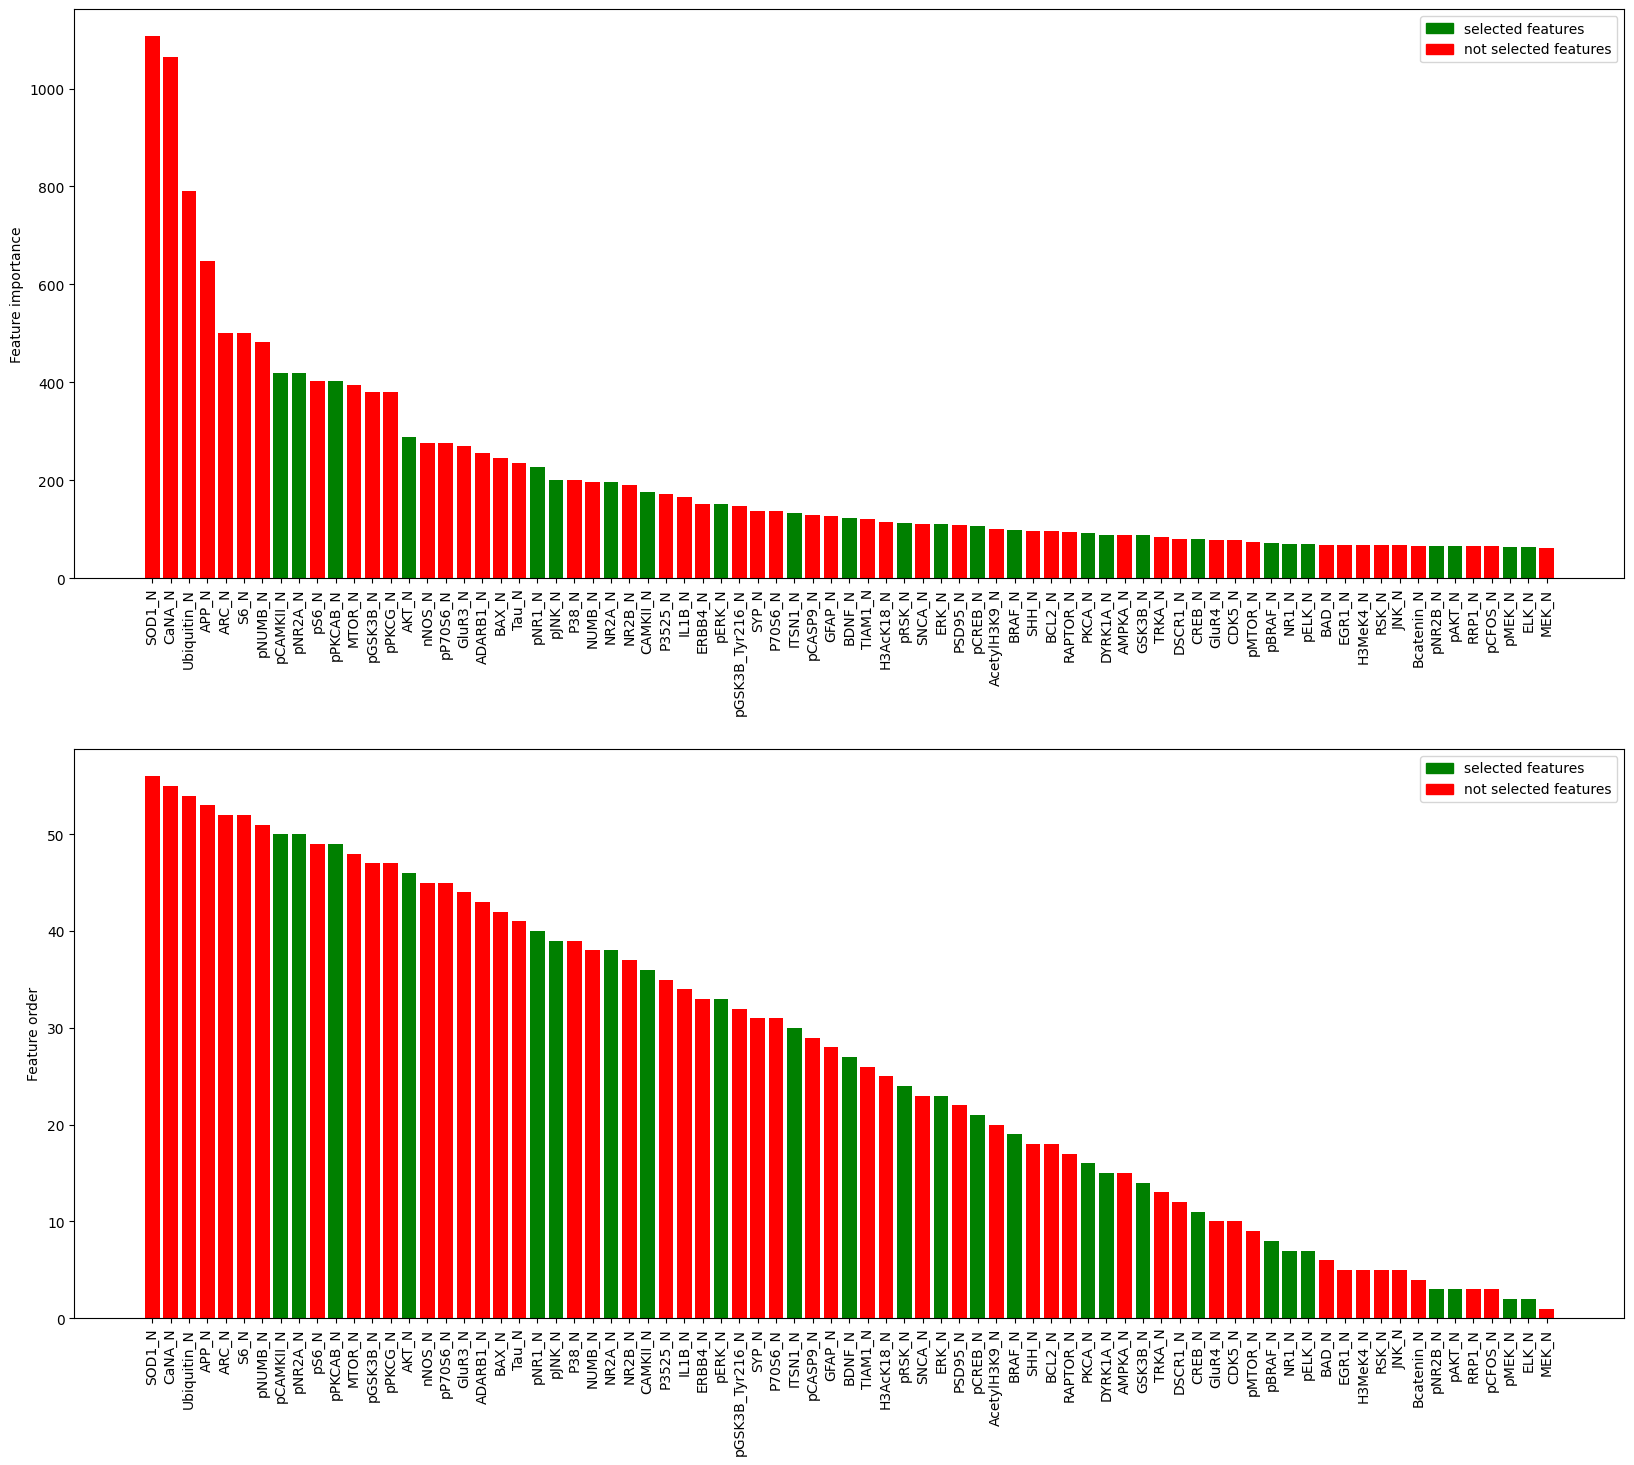

In [87]:
color = np.array(["g"] * true_features + ["r"] * (n_features - true_features))[order]

fig = plt.figure(figsize=(20,17))

plt.subplot(211)
plt.bar(
    np.arange(n_features),
    importances,
    color=color,
)
plt.xticks(np.arange(n_features), ordered_feature_names, rotation=90)
colors = {"selected features": "g", "not selected features": "r"}
labels = list(colors.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.ylabel("Feature importance")

_, order = np.unique(importances, return_inverse=True)

plt.subplot(212)
plt.bar(
    np.arange(n_features),
    order + 1,
    color=color,
)
plt.xticks(np.arange(n_features), ordered_feature_names, rotation=90)
fig.subplots_adjust(hspace=0.3)
plt.legend(handles, labels)
plt.ylabel("Feature order")
plt.show()
plt.close()